In [1]:
%pip install torch torchvision transformers matplotlib numpy pillow

Note: you may need to restart the kernel to use updated packages.


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected knife in image: ../datasets/images/objects/raw\ABbframe00430_jpg.rf.96d982419a6d9599251ac97550753706.jpg (Confidence: 0.951)


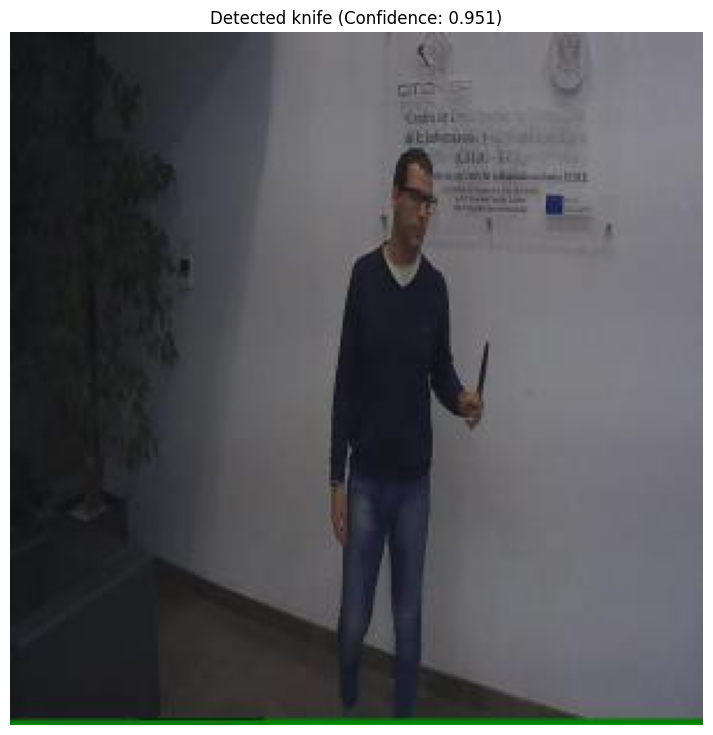

Detected knife in image: ../datasets/images/objects/raw\knife_161.jpg (Confidence: 0.999)


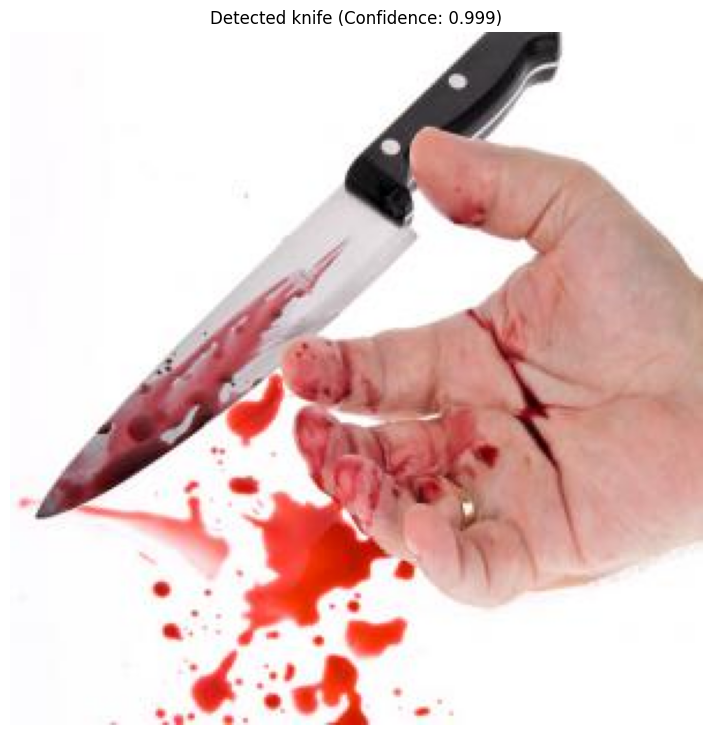

Detected knife in image: ../datasets/images/objects/raw\knife_221_jpg.rf.3b2c59967c14b9d4508d3ca90b677823.jpg (Confidence: 0.906)


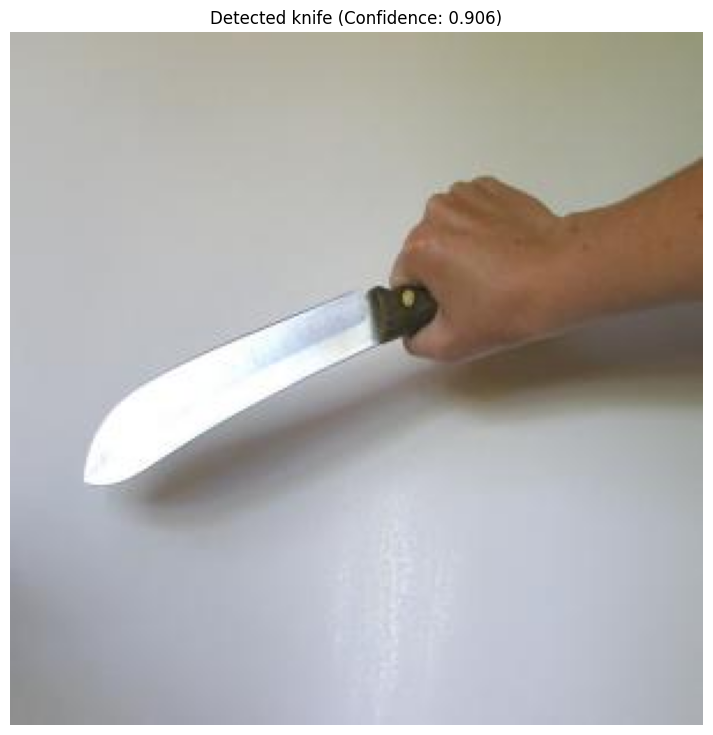

Detected knife in image: ../datasets/images/objects/raw\knife_231_jpg.rf.895856aaa69928c413009ba1210ac3c5.jpg (Confidence: 0.942)


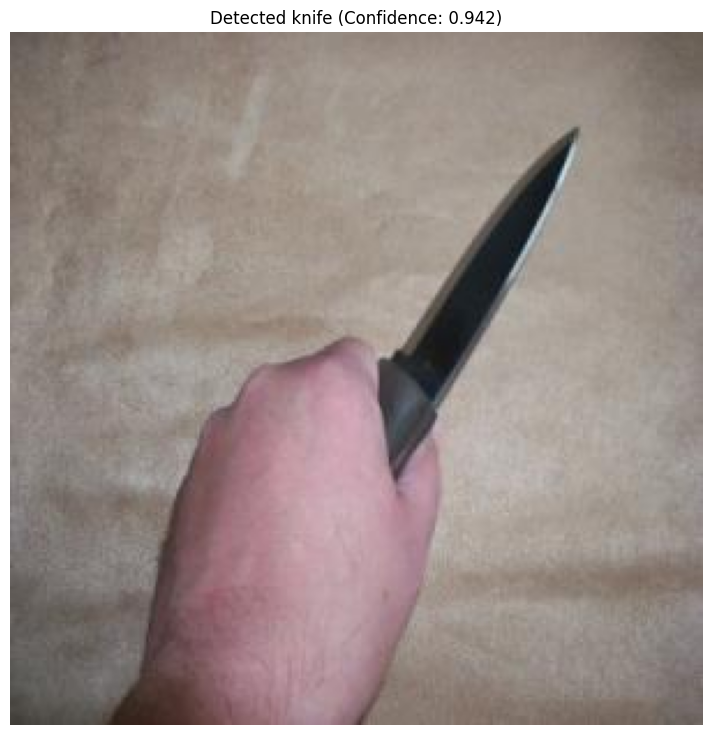

In [2]:
import torch
import os
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained DETR model and processor
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

# Function to load all images in a directory
def load_images_from_directory(directory_path):
    images = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path)
            images.append((image, image_path))
    return images

# Function to perform object detection and filter by query
def detect_objects_in_images(images, query, threshold=0.9):
    matching_images = []
    for image, image_path in images:
        # Process the image
        inputs = processor(images=image, return_tensors="pt")
        
        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process the predictions to filter out low-confidence boxes
        target_sizes = torch.tensor([image.size[::-1]])  # Use image size in (height, width) format
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

        # Check if any of the detected objects match the query (gun, knife, etc.)
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            label_name = model.config.id2label[label.item()]
            if query.lower() in label_name.lower():  # Match object with query (case insensitive)
                matching_images.append((image_path, label_name, round(score.item(), 3)))
                break  # If we found a match for the query, no need to check other objects in this image

    return matching_images

# Function to display matching images
def display_matching_images(matching_images):
    if not matching_images:
        print("No matching objects found.")
        return
    
    for image_path, label_name, score in matching_images:
        print(f"Detected {label_name} in image: {image_path} (Confidence: {score})")
        image = Image.open(image_path)
        
        # Display image
        plt.figure(figsize=(12, 9))
        plt.imshow(np.array(image))
        plt.title(f"Detected {label_name} (Confidence: {score})")
        plt.axis('off')
        plt.show()

# Main function
def main():
    # directory_path = input("Enter the directory path containing images: ")
    # directory_path = input("Enter the directory path containing images: ")
    directory_path = "../datasets/images/objects/raw"
    query = input("Enter the object to search for (e.g., 'gun', 'knife'): ")
    
    # Load all images from the directory
    images = load_images_from_directory(directory_path)
    
    # Perform object detection and filter images based on the query
    matching_images = detect_objects_in_images(images, query)
    
    # Display the matching images
    display_matching_images(matching_images)

if __name__ == "__main__":
    main()


In [ ]:
# Add logic to copy the code to a target directory

import torch
import os
import shutil
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained DETR model and processor
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

# Function to load all images in a directory
def load_images_from_directory(directory_path):
    images = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path)
            images.append((image, image_path))
    return images

# Function to perform object detection and filter by query
def detect_objects_in_images(images, query, threshold=0.9, target_directory=None):
    matching_images = []
    
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)  # Create the target directory if it doesn't exist

    for image, image_path in images:
        # Process the image
        inputs = processor(images=image, return_tensors="pt")
        
        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process the predictions to filter out low-confidence boxes
        target_sizes = torch.tensor([image.size[::-1]])  # Use image size in (height, width) format
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

        # Check if any of the detected objects match the query (gun, knife, etc.)
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            label_name = model.config.id2label[label.item()]
            if query.lower() in label_name.lower():  # Match object with query (case insensitive)
                matching_images.append((image_path, label_name, round(score.item(), 3)))
                
                # Copy the image to the target directory
                shutil.copy(image_path, target_directory)
                break  # If we found a match for the query, no need to check other objects in this image

    return matching_images

# Function to display matching images
def display_matching_images(matching_images):
    if not matching_images:
        print("No matching objects found.")
        return
    
    for image_path, label_name, score in matching_images:
        print(f"Detected {label_name} in image: {image_path} (Confidence: {score})")
        image = Image.open(image_path)
        
        # Display image
        plt.figure(figsize=(12, 9))
        plt.imshow(np.array(image))
        plt.title(f"Detected {label_name} (Confidence: {score})")
        plt.axis('off')
        plt.show()

# Main function
def main():
    directory_path = input("Enter the directory path containing images: ")
    query = input("Enter the object to search for (e.g., 'gun', 'knife'): ")
    target_directory = input("Enter the directory path to copy matching images to: ")

    # Load all images from the directory
    images = load_images_from_directory(directory_path)
    
    # Perform object detection and filter images based on the query
    matching_images = detect_objects_in_images(images, query, target_directory=target_directory)
    
    # Display the matching images
    display_matching_images(matching_images)

if __name__ == "__main__":
    main()


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# DETR and Spacey for Extended Query flexibility
import torch
import os
import shutil
import spacy
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained DETR model and processor
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

# Load the pre-trained spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Function to load all images in a directory
def load_images_from_directory(directory_path):
    images = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path)
            images.append((image, image_path))
    return images

# Function to parse query with spaCy and extract objects to search for
def parse_query(query):
    doc = nlp(query)
    # Extracting nouns (likely objects to search for) from the query
    objects = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
    return objects

# Function to perform object detection and filter by query
def detect_objects_in_images(images, query, threshold=0.9, target_directory=None):
    matching_images = []
    
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)  # Create the target directory if it doesn't exist

    objects_to_search = parse_query(query)  # Get a list of objects to search from the query
    
    for image, image_path in images:
        # Process the image
        inputs = processor(images=image, return_tensors="pt")
        
        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process the predictions to filter out low-confidence boxes
        target_sizes = torch.tensor([image.size[::-1]])  # Use image size in (height, width) format
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

        # Check if any of the detected objects match the query (guns, knives, etc.)
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            label_name = model.config.id2label[label.item()]
            if any(object in label_name.lower() for object in objects_to_search):  # Check if any query object is found
                matching_images.append((image_path, label_name, round(score.item(), 3)))
                
                # Copy the image to the target directory
                shutil.copy(image_path, target_directory)
                break  # If we found a match for the query, no need to check other objects in this image

    return matching_images

# Function to display matching images
def display_matching_images(matching_images):
    if not matching_images:
        print("No matching objects found.")
        return
    
    for image_path, label_name, score in matching_images:
        print(f"Detected {label_name} in image: {image_path} (Confidence: {score})")
        image = Image.open(image_path)
        
        # Display image
        plt.figure(figsize=(12, 9))
        plt.imshow(np.array(image))
        plt.title(f"Detected {label_name} (Confidence: {score})")
        plt.axis('off')
        plt.show()

# Main function
def main():
    directory_path = input("Enter the directory path containing images: ")
    query = input("Enter the object(s) to search for (e.g., 'gun', 'knife', 'guns and knives'): ")
    target_directory = input("Enter the directory path to copy matching images to: ")

    # Load all images from the directory
    images = load_images_from_directory(directory_path)
    
    # Perform object detection and filter images based on the query
    matching_images = detect_objects_in_images(images, query, target_directory=target_directory)
    
    # Display the matching images
    display_matching_images(matching_images)

if __name__ == "__main__":
    main()
